In [1]:
# Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns
import requests as req
import numpy as np

In [2]:
# Cargar el archivo CSV
archivo = "C:/Users/DELL PC/Downloads/iot_sensor_corrupted_dataset.csv"
df = pd.read_csv(archivo)

print("Primeras filas:")
print(df.head())

print("Información general:")
df.info()

print("Estadísticas descriptivas:")
print(df.describe())

Primeras filas:
             timestamp device_id  temperature_C          humidity_% status
0  2030-05-15 00:00:00  ESP32_A2      26.490142  47.391160456649544     OK
1  2023-01-01 00:30:00  ESP32_A2      24.585207   69.17861947054776     OK
2  2023-01-01 01:00:00  ESP32_B1      26.943066               -10.0     OK
3  2023-01-01 01:30:00  ESP32_B1      29.569090   70.32465260551147     OK
4  2023-01-01 02:00:00  ESP32_A1            NaN   44.80630034045987     OK
Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   timestamp      260 non-null    object 
 1   device_id      252 non-null    object 
 2   temperature_C  247 non-null    float64
 3   humidity_%     253 non-null    object 
 4   status         260 non-null    object 
dtypes: float64(1), object(4)
memory usage: 10.3+ KB
Estadísticas descriptivas:
       temperature_C


In [3]:
df.loc[:, 'temperature_C'] = pd.to_numeric(df['temperature_C'], errors='coerce')
df.loc[:, 'humidity_%'] = pd.to_numeric(df['humidity_%'], errors='coerce')
df.loc[:, 'timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

In [5]:
duplicados = df.duplicated().sum()
print(f"Duplicados: {duplicados}")

Duplicados: 8


In [6]:
nulos = df.isnull().sum()
print(f"Valores nulos:\n{nulos}")

Valores nulos:
timestamp         0
device_id         8
temperature_C    13
humidity_%       12
status            0
dtype: int64


In [7]:
fallos = df[df['status'] != 'OK']
print(f"Fallos de sensor: {len(fallos)}")

Fallos de sensor: 70


In [9]:
# Limpieza
df = df.drop_duplicates()
df = df[df['timestamp'].notna()]

In [11]:
for col in df.select_dtypes(include=['float64', 'int64']):
    df[col] = df[col].fillna(df[col].mean())

for col in df.select_dtypes(include=['object']):
    if df[col].isnull().sum() > 0:
        moda = df[col].mode()[0]
        df[col] = df[col].fillna(moda).infer_objects(copy=False)

In [14]:
resumen = df.groupby('device_id').agg({
    'temperature_C': ['mean', 'std', 'min', 'max'],
    'humidity_%': ['mean', 'std', 'min', 'max']
}).round(2)

print("\nResumen por sensor:")
display(resumen)


Resumen por sensor:


temperature_C                        humidity_%               \
                        mean     std    min     max       mean    std   min   
device_id                                                                     
ESP32_A1               69.14  200.65  17.14  999.00      51.43  23.52 -10.0   
ESP32_A2               64.13  188.33  19.12  999.00      57.34  18.07 -10.0   
ESP32_B1               52.24  154.87  19.40  999.00      55.30  21.64 -10.0   
unknown_device         25.10    1.28  23.45   26.57      45.01  31.88 -10.0   

                       
                  max  
device_id              
ESP32_A1        90.79  
ESP32_A2        81.33  
ESP32_B1        81.90  
unknown_device  72.38

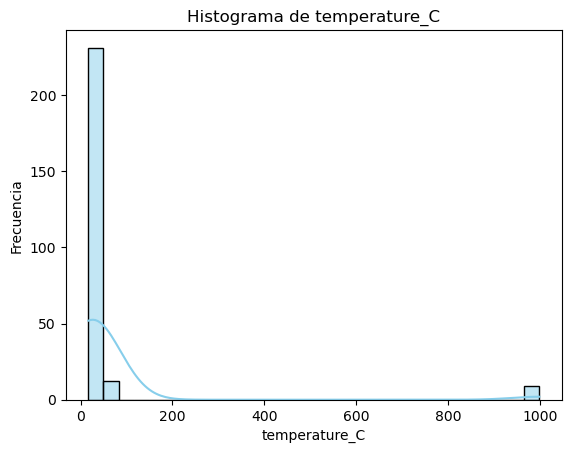

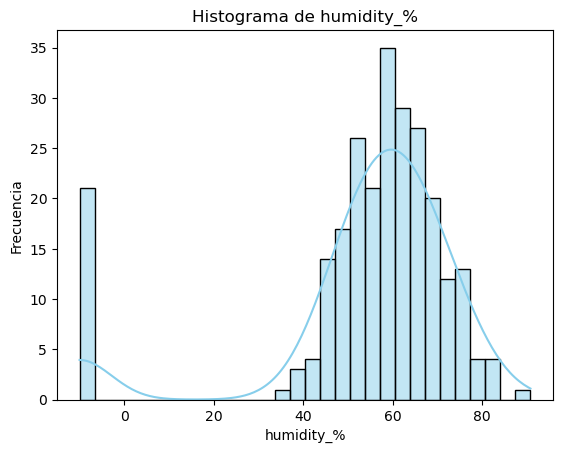

In [19]:
numericas = ['temperature_C', 'humidity_%']

for col in numericas:
    plt.figure()
    sns.histplot(df[col].dropna(), kde=True, bins=30, color='skyblue')
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

Esto permite identificar:

Valores comunes: donde se concentran la mayoría de los registros.

Valores extremos o atípicos: barras aisladas, muy separadas del resto Temperaturas de 999°C.

Distribución de los datos: si los valores están equilibrados (simétricos) o si hay sesgos hacia valores bajos o altos.

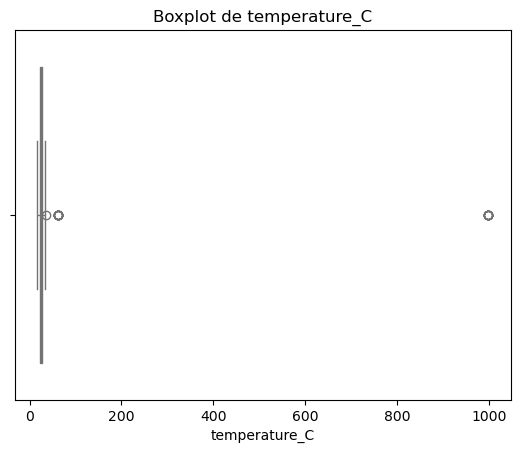

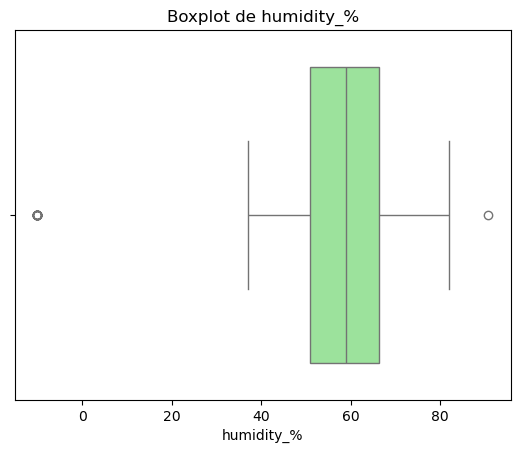

In [21]:
for col in numericas:
    plt.figure()
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f'Boxplot de {col}')
    plt.xlabel(col)
    plt.show()

En temperature_C, los valores extremos como 999 aparecen claramente como puntos aislados, lo que confirma que son errores de medición.

En humidity_%, los valores fuera del rango 0–100% también aparecen como outliers(valor atípico), facilitando su detección.

Se puede ver la simetría o sesgo de los datos: si la mediana está cerca del centro de la caja, la distribución es equilibrada; si no, hay asimetría.

Permite comparar rápidamente la dispersión de los datos entre diferentes variables.

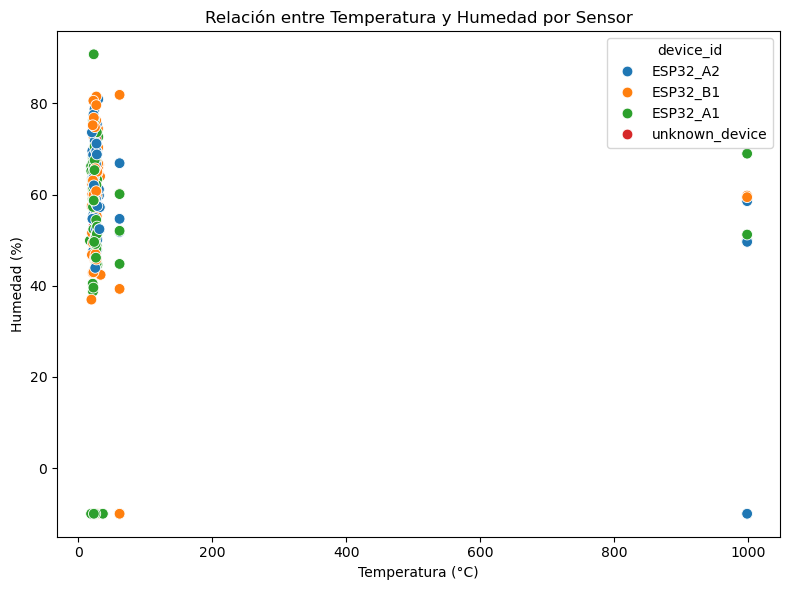

In [24]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='temperature_C', y='humidity_%', hue='device_id', s=60)
plt.title('Relación entre Temperatura y Humedad por Sensor')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Humedad (%)')
plt.tight_layout()
plt.show()

Valores extremos en temperatura (999.0)  por los sensores cuando no pudieron medir correctamente.

Valores fuera de rango en humedad relativa (negativos o mayores a 100%), indicando errores de medición o transmisión.

Filas sin identificación de dispositivo (device_id), generando registros asignados a sensores desconocidos y dificultando el análisis por sensor.

Fechas imposibles o muy lejanas (años superiores a 2030), producto de errores en el reloj del sensor o valores por defecto.

Filas duplicadas, probablemente por reenvíos de datos o errores en la exportación, que inflan estadísticas y distorsionan resultados.